# Expressions

Esta tabla contiene la información a nivel de expression. --> ABEL COMPLETAR <--

## 1 - Obtencion de datos

In [1]:
import matplotlib.pyplot as plt

from notebooks_utils import *

full_table = get_data('expressions')

# Table name, features and target.
TABLE_NAME = 'expressions'
TABLE_FEATURES = ['expression__category','expression__parent','expression__first_child_category','expression__second_child_category','expression__third_child_category','expression__fourth_child_category','expression__expression_role','expression__height','expression__depth','expression__expertise_level']
TABLE_TARGET = 'expression__expertise_level'

# Load features and target.
X, y = full_table[TABLE_FEATURES], full_table[[TABLE_TARGET]].iloc[:,0]

# Print information about the loaded table.
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

print(f'As we can see the downloaded data contains a total of {X.shape[0]} instances. Each of the instances corresponds to a program. For each program we have {X.shape[1]} attributes.')

2024-05-26 19:30:02.297106 Data cache files found ...
2024-05-26 19:30:07.348606 Data cache files successfully loaded!!
Features shape: (5248119, 10)
Target shape: (5248119,)
As we can see the downloaded data contains a total of 5248119 instances. Each of the instances corresponds to a program. For each program we have 10 attributes.


## 2 - Exploracion de datos

Una vez tenemos nuestra tabla en un dataframe el siguiente paso es explorarla para ver qué tipo de información contiene.

In [2]:
print(X.info())
print('=============')
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5248119 entries, 0 to 5248118
Data columns (total 10 columns):
 #   Column                             Dtype 
---  ------                             ----- 
 0   expression__category               object
 1   expression__parent                 object
 2   expression__first_child_category   object
 3   expression__second_child_category  object
 4   expression__third_child_category   object
 5   expression__fourth_child_category  object
 6   expression__expression_role        object
 7   expression__height                 int64 
 8   expression__depth                  int64 
 9   expression__expertise_level        object
dtypes: int64(2), object(8)
memory usage: 400.4+ MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 5248119 entries, 0 to 5248118
Series name: expression__expertise_level
Non-Null Count    Dtype 
--------------    ----- 
5248119 non-null  object
dtypes: object(1)
memory usage: 40.0+ MB
None


Cómo podemos ver la tabla está compuesta por 2 variables numéricas y 8 de tipo objeto (cetegoricas). Una de ellas es la clase con la que se ha etiquetado la instancia. Sin embargo, en algunas ocasiones esta última clase no la vamos a utilizar. Por ejemplo, si queremos obtener clusters por medio de aprendizaje no supervisado.

### 2.1 - Balance de clases

In [3]:
instances_for_class_low = len(full_table[full_table[TABLE_TARGET] == "BEGINNER"])
instances_for_class_high = len(full_table[full_table[TABLE_TARGET] == "EXPERT"])

print(f"The dataset contains {instances_for_class_low/len(full_table)*100:.4}% instances for BEGINNER class and {instances_for_class_high/len(full_table)*100:.4}% for EXPERT class.")

The dataset contains 66.51% instances for BEGINNER class and 33.49% for EXPERT class.


### 2.2 - Duplicados
Miramos si la tabla tiene entradas duplicadas.

In [4]:
number_of_duplicated_entries = sum(full_table.duplicated(subset=TABLE_FEATURES + [TABLE_TARGET]))
duplicated_entries_pct = number_of_duplicated_entries / len(full_table) * 100
print(f"The dataset contains [{duplicated_entries_pct:.4}%] of duplicated entries.")

The dataset contains [98.47%] of duplicated entries.


### 2.3 - Valores Nulos 
Miramos si alguna de las variables que contiene la tabla contiene algún valor que sea nulo.

In [5]:
X.isnull().sum()

expression__category                       0
expression__parent                         0
expression__first_child_category     3529370
expression__second_child_category    4409862
expression__third_child_category     5016030
expression__fourth_child_category    5170020
expression__expression_role                0
expression__height                         0
expression__depth                          0
expression__expertise_level                0
dtype: int64

Aunque una columna no contenga valores nulos podría ser que contenga valores vacíos. Si los hubiese la siguiente función los mostraría.

In [6]:
print_empty_cols(X)

expression__category
--------------------
0 instancias no tienen un valor para la columna expression__category


expression__parent
------------------
0 instancias no tienen un valor para la columna expression__parent


expression__first_child_category
--------------------------------
0 instancias no tienen un valor para la columna expression__first_child_category


expression__second_child_category
---------------------------------
0 instancias no tienen un valor para la columna expression__second_child_category


expression__third_child_category
--------------------------------
0 instancias no tienen un valor para la columna expression__third_child_category


expression__fourth_child_category
---------------------------------
0 instancias no tienen un valor para la columna expression__fourth_child_category


expression__expression_role
---------------------------
0 instancias no tienen un valor para la columna expression__expression_role


expression__height
------------------
0 inst

### 2.4 - Describimos los valores de las variables de la tabla.

In [7]:
np.transpose(X.describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int']))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
expression__category,5248119,39,Variable,1618012,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__parent,5248119,49,Call,1092520,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__first_child_category,1718749,37,Variable,820738,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__second_child_category,838257,35,Variable,261656,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__third_child_category,232089,35,StringLiteral,79739,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__fourth_child_category,78099,31,Variable,20782,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__expression_role,5248119,77,TupleLiteral,758530,NaN,NaN,NaN,NaN,NaN,NaN,NaN
expression__height,5248119.0,NaN,NaN,NaN,5.173391,2.373495,1.0,4.0,5.0,6.0,83.0
expression__depth,5248119.0,NaN,NaN,NaN,0.530213,1.048245,0.0,0.0,0.0,1.0,81.0
expression__expertise_level,5248119,2,BEGINNER,3490521,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vamos a discretizar las variables numericas, agrupando conjuntos de valores en categorias, para hacer un análisis de los datos. Para cada variable es necesaario ver la distribucion de lo valores para hacer los bins (categorias). Revisar programa con 3k modulos y 1k paquetes.

In [8]:
# DISCRETIZATION
X_copy = X.copy()

discretized_columns = {
    "expression__height": [(1, 3), (3, 4), (4, 5), (5, 6) ,(6, 7), (7, inf)],  # min: 1 max: 83
    "expression__depth": [(0, 1), (1, 2), (2, inf)],  # min: 1 max: 81
}

discretize_columns(X_copy, discretized_columns)
    
# SINGLE FEATURE
print("--- SINGLE FEATURE ---")
print(get_statistics(X_copy, ['expression__category'], 10))
print(get_statistics(X_copy, ['expression__parent'], 10))
print(get_statistics(X_copy, ['expression__first_child_category'], 10))
print(get_statistics(X_copy, ['expression__second_child_category'], 10))
print(get_statistics(X_copy, ['expression__third_child_category'], 10))
print(get_statistics(X_copy, ['expression__fourth_child_category'], 10))
print(get_statistics(X_copy, ['expression__expression_role'], 10))
print(get_statistics(X_copy, ['expression__height'], 10))
print(get_statistics(X_copy, ['expression__depth'], 10))

# 2 FEATURES
print("--- TWO FEATURES ---")
print(get_statistics(X_copy, ['expression__category', 'expression__expression_role'], 10))
print(get_statistics(X_copy, ['expression__category', 'expression__parent'], 10))
print(get_statistics(X_copy, ['expression__parent', 'expression__expression_role'], 10))


# 3 FEATURES
print("--- THREE FEATURES ---")
print(get_statistics(X_copy, ['expression__category', 'expression__first_child_category', 'expression__second_child_category'], 10))


--- SINGLE FEATURE ---
expression__category   count  percentage
            Variable 1618012   30.830322
          IntLiteral  895451   17.062323
       StringLiteral  784753   14.953034
                 Dot  506532    9.651687
                Call  467789    8.913460
        TupleLiteral  186529    3.554207
     UnaryArithmetic  140617    2.679379
        FloatLiteral  138187    2.633077
             Compare  106076    2.021219
            Indexing   99896    1.903463

expression__parent   count  percentage
              Call 1092520   20.817363
      TupleLiteral  758530   14.453369
 DictionaryLiteral  752769   14.343596
    AssignmentStmt  569966   10.860386
               Dot  506532    9.651687
           Compare  213306    4.064428
          Indexing  199792    3.806926
                If  175102    3.336472
        Arithmetic  162624    3.098710
   UnaryArithmetic  140617    2.679379

expression__first_child_category  count  percentage
                        Variable 820738   1

In [9]:
def normalize_datatypes(X:pd.DataFrame, y:pd.Series) -> (pd.DataFrame, pd.Series, [str]):
    X = pd.get_dummies(X)
    X = X.astype('float32')
    y = y.apply(lambda value: 0 if value == "BEGINNER" else 1) # EXPERT will be 1 and BEGINNER will be 0.
    y = y.astype('float32')
    columns_names = X.columns.tolist()
    return X, y, columns_names

X, y, TABLE_FEATURES = normalize_datatypes(X, y)
# Print information about the loaded table
print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')

Features shape: (5248119, 307)
Target shape: (5248119,)


#### Muestra la matriz de correlación de pearson entre las variables de la tabla.

In [10]:
# Con estos datos (8102385, 316) la matriz de confusion es demasiado grande.
# sns.heatmap(X.corr(), annot=True)

## 3 - Detección de valores atípicos (outliers)
Una vez sabemos qué datos contiene la tabla, analizaremos los valores que toma cada una de las variables de cada instancia. El objetivo es identificar posibles valores atípicos que nos dificulten la realización de futuras tareas. 
Tras su análisis, se puede concluir que un valor:
    - **Es erróneo**. En este caso hay que tomar una decisión para cada caso, siendo los tratamientos más extendidos son listwise, pairwise, drop variables, mean/median imputation, most frequent, separate category, zero imputation, cold deck, hot deck,(stochastic) regression, k-NN and multiple imputation. Los resultados de imputación regresiva, k-NN y múltiple dan buenos resultados, aunque, como se ha indicado, es necesario el estudio en cada caso.
    - **Es correcto, pero anómalo**. Se documenta su existencia para su posible discusión y se mantiene en el dataset. En estos casos se hace necesaria la utilización de algoritmos y estadísticos que no sean muy sensibles a dichos valores anómalos.

## Univariate
Para cada uno de los atributos se debe realizar un análisis y detección de valores atípicos, estudiando su posible causa. 
Existen diversas formas de calcular los valores anómalos. 

### Variables numéricas
Para las variables numéricas, se suele identificar: 
    - a) Valor atípico leve es el que está fuera de $[Q1 - 1.5IQR, Q3 + 1.5IQR]$, donde $IQR = Q3-Q1$.
    - b) Valor atípico extremo está fuera de $[Q1 - 3IQR, Q3 + 3IQR]$.

La idea es probar con a) y si hay pocas instancias analizarlas. Si hubiese muchas, mirar b) y analizar si fuesen pocas. No hay un algoritmo o método estipulado, puesto que depende del dominio del problema y de los datos.

Los límites de Tukey se basan en los cuartiles de los datos y son sensibles a la presencia de sesgo en la distribución. Cuando hay asimetría en los datos, los límites de Tukey pueden no ser tan efectivos para identificar outliers de manera equitativa en ambos extremos de la distribución. El Coeficiente de Medcouple es útil para identificar la asimetría en los datos, especialmente en presencia de valores atípicos o sesgados. Es una medida robusta porque no se ve tan afectada por valores extremos como la media y la desviación estándar. El MC puede proporcionar información adicional sobre la asimetría de la distribución, lo que te permite ajustar los límites de Tukey de manera más apropiada para tu conjunto de datos específico. Una posible variacion de los límites de Tukey teniendo en cuenta MC podria ser: 
   - Si MC es mayor que 0 (asimetría hacia la derecha):
      - low = (q1-1.5 * math.exp(-4*mc) * iqr)
      - high = (q3+1.5 * math.exp(3.5*mc) * iqr)
   - Si la asimetriza es hacia la izquierda:    
      - low = (q1-1.5 * math.exp(-3.5*mc) * iqr)
      - high = (q3+1.5 * math.exp(4*mc) * iqr)


### Variables categóricas
Para las variables categóricas no existe el concepto de valor anómalo, pero sí se puede considerar en base a un análisis de frecuencia. Por ejemplo, que el uso de una categoría sea residual, pudiendo tener un 0.1% de instancias en el dataset. Para detectar estos valores, se puede fijar un valor mínimo de frecuencia en función del número posible de valores de la variable categórica (2 en el caso de una variable booleana). Por ejemplo, un umbral de $\frac{0.2\%}{valores}$ (0.1% en el caso de una variable booleana)

## Analisis detallado de variables
Para cada una de las 9 variable (7 categoricas y 2 numericas) se hara un analisis detallado 

### Variable category (1/9)
Esta variable es de tipo categorica y representa la categoria de la expresion.

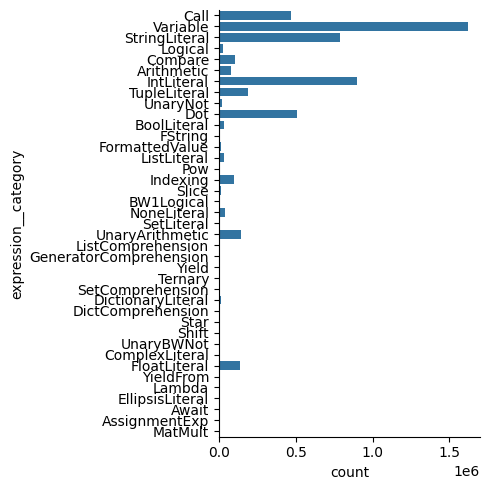

In [11]:
sns.catplot(full_table['expression__category'], kind="count")

In [4]:
possible_values = ['Logical', 'AssignmentExp', 'Arithmetic', 'Pow', 'Shift', 'BW1Logical', 'MatMult', 'UnaryArithmetic', 'UnaryNot', 'UnaryBWNot', 'Lambda', 'Ternary', 'SetLiteral', 'ListLiteral', 'TupleLiteral', 'DictionaryLiteral', 'ListComprehension', 'SetComprehension', 'DictComprehension', 'GeneratorComprehension', 'Await', 'Yield', 'YieldFrom', 'Compare', 'Call', 'FString', 'FormattedValue', 'IntLiteral', 'FloatLiteral', 'ComplexLiteral', 'NoneLiteral', 'BoolLiteral', 'StringLiteral', 'EllipsisLiteral', 'Dot', 'Variable', 'Slice', 'Indexing', 'Star']
print_frequency_anal_for_cat_var(full_table, 'expression__category', possible_values)

NameError: name 'print_frequency_anal_for_cat_var' is not defined

### Variable parent (2/9)
Esta variable es de tipo categorica y representa la categoria del padre de la expresion.

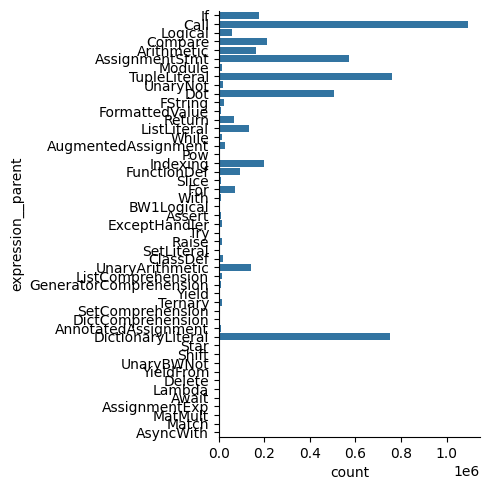

In [13]:
sns.catplot(full_table['expression__parent'], kind="count")

In [3]:
possible_values = ['Return', 'Delete', 'AssignmentStmt', 'TypeAlias', 'AugmentedAssignment', 'AnnotatedAssignment', 'For', 'If', 'While', 'With', 'AsyncWith', 'Match', 'Raise', 'Try', 'Assert', 'Global', 'NonLocal', 'Pass', 'Break', 'Continue', 'ExceptHandler', 'Import', 'ImportFrom', 'Logical', 'AssignmentExp', 'Arithmetic', 'Pow', 'Shift', 'BW1Logical', 'MatMult', 'UnaryArithmetic', 'UnaryNot', 'UnaryBWNot', 'Lambda', 'Ternary', 'SetLiteral', 'ListLiteral', 'TupleLiteral', 'DictionaryLiteral', 'ListComprehension', 'SetComprehension', 'DictComprehension', 'GeneratorComprehension', 'Await', 'Yield', 'YieldFrom', 'Compare', 'Call', 'FString', 'FormattedValue', 'IntLiteral', 'FloatLiteral', 'ComplexLiteral', 'NoneLiteral', 'BoolLiteral', 'StringLiteral', 'EllipsisLiteral', 'Dot', 'Variable', 'Slice', 'Indexing', 'Star', 'Module', 'ClassDef', 'FunctionDef', 'MethodDef']
print_frequency_anal_for_cat_var(full_table, 'expression__parent', possible_values)

NameError: name 'print_frequency_anal_for_cat_var' is not defined

### Variable first_child_category (3/9)
Esta variable es de tipo categorica y representa la categoria del primer hijo de la expresion.

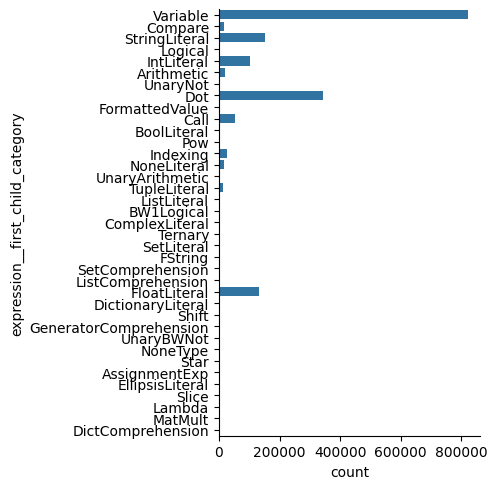

In [15]:
sns.catplot(full_table['expression__first_child_category'], kind="count")

In [16]:
possible_values = ['Logical', 'AssignmentExp', 'Arithmetic', 'Pow', 'Shift', 'BW1Logical', 'MatMult', 'UnaryArithmetic', 'UnaryNot', 'UnaryBWNot', 'Lambda', 'Ternary', 'SetLiteral', 'ListLiteral', 'TupleLiteral', 'DictionaryLiteral', 'ListComprehension', 'SetComprehension', 'DictComprehension', 'GeneratorComprehension', 'Await', 'Yield', 'YieldFrom', 'Compare', 'Call', 'FString', 'FormattedValue', 'IntLiteral', 'FloatLiteral', 'ComplexLiteral', 'NoneLiteral', 'BoolLiteral', 'StringLiteral', 'EllipsisLiteral', 'Dot', 'Variable', 'Slice', 'Indexing', 'Star', 'Parameter']
print_frequency_anal_for_cat_var(full_table, 'expression__first_child_category', possible_values)

La variable expression__first_child_category contiene 38 valores distintos.
El umbral de outlier es de 0.005263157894736842%
La variable expression__first_child_category toma el valor de Variable en un 15.64% de los items.
La variable expression__first_child_category toma el valor de Dot en un 6.567% de los items.
La variable expression__first_child_category toma el valor de StringLiteral en un 2.903% de los items.
La variable expression__first_child_category toma el valor de FloatLiteral en un 2.514% de los items.
La variable expression__first_child_category toma el valor de IntLiteral en un 1.939% de los items.
La variable expression__first_child_category toma el valor de Call en un 1.017% de los items.
La variable expression__first_child_category toma el valor de Indexing en un 0.5346% de los items.
La variable expression__first_child_category toma el valor de Arithmetic en un 0.3664% de los items.
La variable expression__first_child_category toma el valor de NoneLiteral en un 0.334

### Variable second_child_category (4/9)
Esta variable es de tipo categorica y representa la categoria del segundo hijo de la expresion.

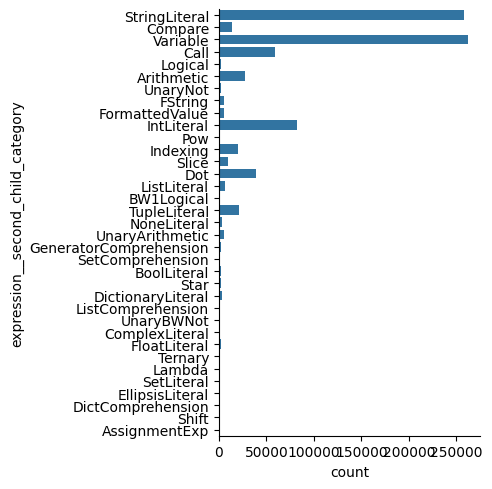

In [17]:
sns.catplot(full_table['expression__second_child_category'], kind="count")

In [18]:
possible_values = ['Logical', 'AssignmentExp', 'Arithmetic', 'Pow', 'Shift', 'BW1Logical', 'MatMult', 'UnaryArithmetic', 'UnaryNot', 'UnaryBWNot', 'Lambda', 'Ternary', 'SetLiteral', 'ListLiteral', 'TupleLiteral', 'DictionaryLiteral', 'ListComprehension', 'SetComprehension', 'DictComprehension', 'GeneratorComprehension', 'Await', 'Yield', 'YieldFrom', 'Compare', 'Call', 'FString', 'FormattedValue', 'IntLiteral', 'FloatLiteral', 'ComplexLiteral', 'NoneLiteral', 'BoolLiteral', 'StringLiteral', 'EllipsisLiteral', 'Dot', 'Variable', 'Slice', 'Indexing', 'Star', 'Parameter']
print_frequency_anal_for_cat_var(full_table, 'expression__second_child_category', possible_values)

La variable expression__second_child_category contiene 36 valores distintos.
El umbral de outlier es de 0.005555555555555556%
La variable expression__second_child_category toma el valor de Variable en un 4.986% de los items.
La variable expression__second_child_category toma el valor de StringLiteral en un 4.917% de los items.
La variable expression__second_child_category toma el valor de IntLiteral en un 1.558% de los items.
La variable expression__second_child_category toma el valor de Call en un 1.126% de los items.
La variable expression__second_child_category toma el valor de Dot en un 0.7401% de los items.
La variable expression__second_child_category toma el valor de Arithmetic en un 0.5179% de los items.
La variable expression__second_child_category toma el valor de TupleLiteral en un 0.4052% de los items.
La variable expression__second_child_category toma el valor de Indexing en un 0.3925% de los items.
La variable expression__second_child_category toma el valor de Compare en 

### Variable third_child_category (5/9)
Esta variable es de tipo categorica y representa la categoria del tercer hijo de la expresion.

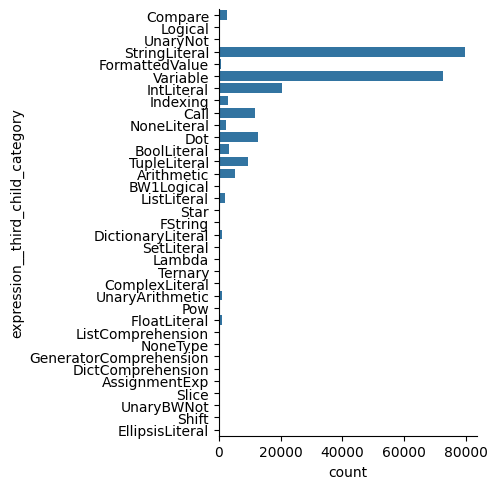

In [19]:
sns.catplot(full_table['expression__third_child_category'], kind="count")

In [20]:
possible_values = ['Logical', 'AssignmentExp', 'Arithmetic', 'Pow', 'Shift', 'BW1Logical', 'MatMult', 'UnaryArithmetic', 'UnaryNot', 'UnaryBWNot', 'Lambda', 'Ternary', 'SetLiteral', 'ListLiteral', 'TupleLiteral', 'DictionaryLiteral', 'ListComprehension', 'SetComprehension', 'DictComprehension', 'GeneratorComprehension', 'Await', 'Yield', 'YieldFrom', 'Compare', 'Call', 'FString', 'FormattedValue', 'IntLiteral', 'FloatLiteral', 'ComplexLiteral', 'NoneLiteral', 'BoolLiteral', 'StringLiteral', 'EllipsisLiteral', 'Dot', 'Variable', 'Slice', 'Indexing', 'Star', 'Parameter']
print_frequency_anal_for_cat_var(full_table, 'expression__third_child_category', possible_values)

La variable expression__third_child_category contiene 36 valores distintos.
El umbral de outlier es de 0.005555555555555556%
La variable expression__third_child_category toma el valor de StringLiteral en un 1.519% de los items.
La variable expression__third_child_category toma el valor de Variable en un 1.386% de los items.
La variable expression__third_child_category toma el valor de IntLiteral en un 0.3896% de los items.
La variable expression__third_child_category toma el valor de Dot en un 0.2403% de los items.
La variable expression__third_child_category toma el valor de Call en un 0.2202% de los items.
La variable expression__third_child_category toma el valor de TupleLiteral en un 0.1803% de los items.
La variable expression__third_child_category toma el valor de Arithmetic en un 0.09901% de los items.
La variable expression__third_child_category toma el valor de BoolLiteral en un 0.06433% de los items.
La variable expression__third_child_category toma el valor de Indexing en un

### Variable fourth_child_category (6/9)
Esta variable es de tipo categorica y representa la categoria del cuarto hijo de la expresion.

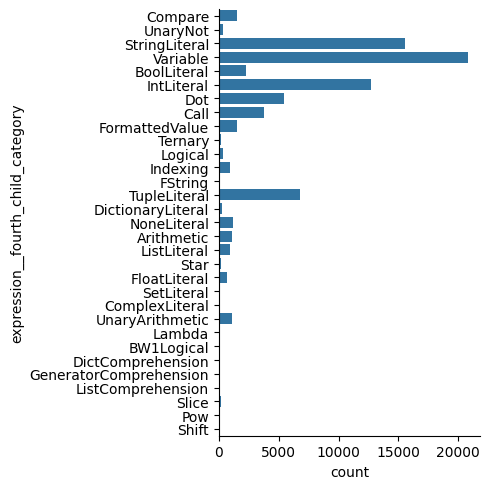

In [21]:
sns.catplot(full_table['expression__fourth_child_category'], kind="count")

In [22]:
possible_values = ['Logical', 'AssignmentExp', 'Arithmetic', 'Pow', 'Shift', 'BW1Logical', 'MatMult', 'UnaryArithmetic', 'UnaryNot', 'UnaryBWNot', 'Lambda', 'Ternary', 'SetLiteral', 'ListLiteral', 'TupleLiteral', 'DictionaryLiteral', 'ListComprehension', 'SetComprehension', 'DictComprehension', 'GeneratorComprehension', 'Await', 'Yield', 'YieldFrom', 'Compare', 'Call', 'FString', 'FormattedValue', 'IntLiteral', 'FloatLiteral', 'ComplexLiteral', 'NoneLiteral', 'BoolLiteral', 'StringLiteral', 'EllipsisLiteral', 'Dot', 'Variable', 'Slice', 'Indexing', 'Star', 'Parameter']
print_frequency_anal_for_cat_var(full_table, 'expression__fourth_child_category', possible_values)

La variable expression__fourth_child_category contiene 32 valores distintos.
El umbral de outlier es de 0.00625%
La variable expression__fourth_child_category toma el valor de Variable en un 0.396% de los items.
La variable expression__fourth_child_category toma el valor de StringLiteral en un 0.2961% de los items.
La variable expression__fourth_child_category toma el valor de IntLiteral en un 0.2418% de los items.
La variable expression__fourth_child_category toma el valor de TupleLiteral en un 0.1298% de los items.
La variable expression__fourth_child_category toma el valor de Dot en un 0.1037% de los items.
La variable expression__fourth_child_category toma el valor de Call en un 0.07153% de los items.
La variable expression__fourth_child_category toma el valor de BoolLiteral en un 0.04322% de los items.
La variable expression__fourth_child_category toma el valor de FormattedValue en un 0.02904% de los items.
La variable expression__fourth_child_category toma el valor de Compare en 

### Variable expression_role (7/9)
Esta variable es de tipo categorica y representa el rol de la expresion en su padre.

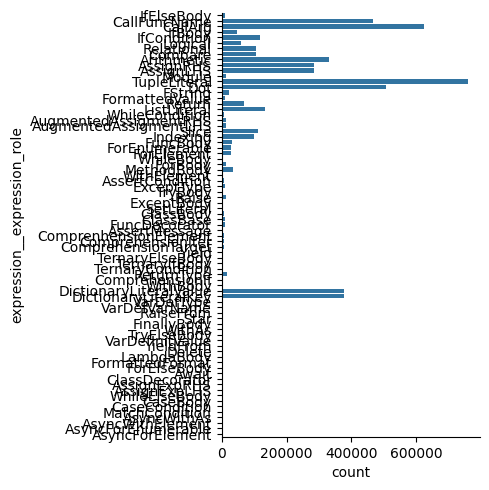

In [23]:
sns.catplot(full_table['expression__expression_role'], kind="count")

In [24]:
possible_values = ['Module', 'FuncDecorator', 'FuncBody', 'ReturnType', 'ClassBase', 'ClassDecorator', 'MethodBody', 'ClassBody', 'Return', 'Delete', 'AssignLHS', 'AssignRHS', 'TypeAliasLHS', 'TypeAliasRHS', 'AugmentedAssignmentLHS', 'AugmentedAssignmentRHS', 'VarDefVarName', 'VarDefType', 'VarDefInitValue', 'ForElement', 'ForEnumerable', 'ForBody', 'ForElseBody', 'AsyncForElement', 'AsyncForEnumerable', 'AsyncForBody', 'AsyncForElseBody', 'WhileCondition', 'WhileBody', 'WhileElseBody', 'IfCondition', 'IfBody', 'IfElseBody', 'WithElement', 'WithAs', 'WithBody', 'AsyncWithElement', 'AsyncWithAs', 'AsyncWithBody', 'MatchCondition', 'CaseCondition', 'CaseGuard', 'CaseBody', 'Raise', 'RaiseFrom', 'TryBody', 'ExceptType', 'ExceptBody', 'TryElse', 'FinallyBody', 'AssertCondition', 'AssertMessage', 'Logical', 'AssignExpLHS', 'AssignExpRHS', 'Arithmetic', 'Pow', 'Shift', 'BW1Logical', 'MatMult', 'LambdaBody', 'TernaryCondition', 'TernaryIfBody', 'TernaryElseBody', 'SetLiteral', 'ListLiteral', 'TupleLiteral', 'DictionaryLiteralKey', 'DictionaryLiteralValue', 'ComprehensionElement', 'ComprehensionTarget', 'ComprehensionIter', 'ComprehensionIf', 'Await', 'Yield', 'YieldFrom', 'Relational', 'Is', 'In', 'CallFuncName', 'CallArg', 'FString', 'Dot', 'Slice', 'Indexing', 'Star', 'TypeAnnotation', 'DefaultParamValue', 'TypeVar']
print_frequency_anal_for_cat_var(full_table, 'expression__expression_role', possible_values)

La variable expression__expression_role contiene 77 valores distintos.
El umbral de outlier es de 0.0025974025974025974%
La variable expression__expression_role toma el valor de TupleLiteral en un 14.45% de los items.
La variable expression__expression_role toma el valor de CallArg en un 11.9% de los items.
La variable expression__expression_role toma el valor de Dot en un 9.652% de los items.
La variable expression__expression_role toma el valor de CallFuncName en un 8.913% de los items.
La variable expression__expression_role toma el valor de DictionaryLiteralValue en un 7.181% de los items.
La variable expression__expression_role toma el valor de DictionaryLiteralKey en un 7.179% de los items.
La variable expression__expression_role toma el valor de Arithmetic en un 6.302% de los items.
La variable expression__expression_role toma el valor de AssignLHS en un 5.441% de los items.
La variable expression__expression_role toma el valor de AssignRHS en un 5.419% de los items.
La variable

### Variable height (8/9)
Esta variable representa la distancia de la expresión al root del módulo (fichero). Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 1 - 87. Con una media de 5.169.

<Axes: ylabel='expression__height'>

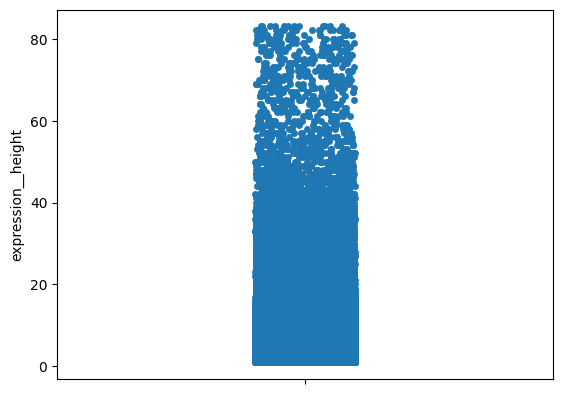

In [25]:
sns.stripplot(X['expression__height'])

In [26]:
print_outliers_for_df_column(X, 'expression__height')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.8634668181582195
Rango valores atípicos extremos (Tukey): [-2.0,12.0]
Rango valores atípicos leves (Tukey): [1.0,9.0]
Rango valores atípicos extremos (Fixed BoxPlot): [3.8539084172593707,100.86734632362732]
-3.0IQR: 0 instancias tienen un valor para expression__height inferior a -2.0 (Q1-3*IQR) para expression__height. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para expression__height inferior a 1.0 (Q1-1.5*IQR) para expression__height. Representando un 0.0% del total de instancias.
+1.5IQR: 196852 instancias tienen un valor para expression__height superior a 9.0 (Q3+1.5*IQR) para expression__height. Representando un 3.751% del total de instancias.
+3.0IQR: 45885 instancias tienen un valor para expression__height superior a 12.0 (Q3-3*IQR) para expression__height. Representando un 0.8743% del total de instancias.
L: 883185 instancias tienen un valor para expression__height inferior a 3

In [27]:
X[X['expression__height'] > 12].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,expression__height,expression__depth,expression__category_Arithmetic,expression__category_AssignmentExp,expression__category_Await,expression__category_BW1Logical,expression__category_BoolLiteral,expression__category_Call,expression__category_Compare,expression__category_ComplexLiteral,...,expression__expression_role_WhileBody,expression__expression_role_WhileCondition,expression__expression_role_WhileElseBody,expression__expression_role_WithAs,expression__expression_role_WithBody,expression__expression_role_WithElement,expression__expression_role_Yield,expression__expression_role_YieldFrom,expression__expertise_level_BEGINNER,expression__expertise_level_EXPERT
count,45885.000000,45885.000000,45885.000000,45885.0,45885.0,45885.000000,45885.000000,45885.000000,45885.000000,45885.0,...,45885.000000,45885.000000,45885.0,45885.0,45885.0,45885.0,45885.0,45885.0,45885.000000,45885.000000
mean,18.262657,0.868497,0.043871,0.0,0.0,0.002528,0.004729,0.083273,0.035916,0.0,...,0.000065,0.000283,0.0,0.0,0.0,0.0,0.0,0.0,0.689920,0.310080
std,9.115787,3.981165,0.204809,0.0,0.0,0.050217,0.068607,0.276298,0.186082,0.0,...,0.008086,0.016830,0.0,0.0,0.0,0.0,0.0,0.0,0.462531,0.462531
min,13.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
25%,13.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
50%,15.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000
75%,18.000000,1.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000
max,83.000000,70.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,0.0,...,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000


### Variable depth (9/9)
Esta variable representa la distancia desde la expresion hasta una hoja del ast. Como vimos en la descripción de la tabla esta varibale adopta valores en el rango 0 - 81. Con una media de 0.60.

<Axes: ylabel='expression__depth'>

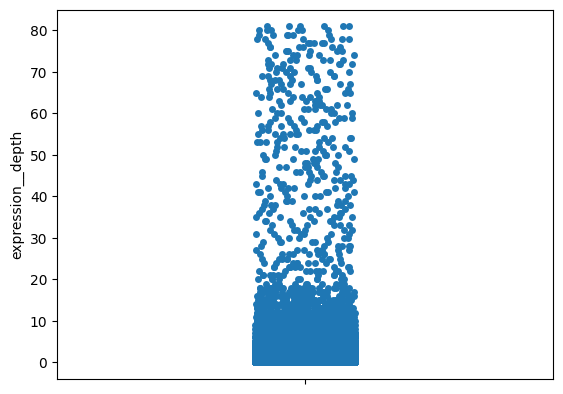

In [28]:
sns.stripplot(X['expression__depth'])

In [29]:
print_outliers_for_df_column(X, 'expression__depth')

El coeficiente MC (Medcouple Coefficient) de balanceo es: 0.5371200494969853
Rango valores atípicos extremos (Tukey): [-3.0,4.0]
Rango valores atípicos leves (Tukey): [-1.5,2.5]
Rango valores atípicos extremos (Fixed BoxPlot): [-0.22890343052536113,13.85773153260522]
-3.0IQR: 0 instancias tienen un valor para expression__depth inferior a -3.0 (Q1-3*IQR) para expression__depth. Representando un 0.0% del total de instancias.
-1.5IQR: 0 instancias tienen un valor para expression__depth inferior a -1.5 (Q1-1.5*IQR) para expression__depth. Representando un 0.0% del total de instancias.
+1.5IQR: 245072 instancias tienen un valor para expression__depth superior a 2.5 (Q3+1.5*IQR) para expression__depth. Representando un 4.67% del total de instancias.
+3.0IQR: 33417 instancias tienen un valor para expression__depth superior a 4.0 (Q3-3*IQR) para expression__depth. Representando un 0.6367% del total de instancias.
L: 0 instancias tienen un valor para expression__depth inferior a -0.228903430525

In [30]:
X[X['expression__depth'] > 4].describe(percentiles=[.25, .50, .75], include = ['object', 'float', 'bool', 'int'])

,expression__height,expression__depth,expression__category_Arithmetic,expression__category_AssignmentExp,expression__category_Await,expression__category_BW1Logical,expression__category_BoolLiteral,expression__category_Call,expression__category_Compare,expression__category_ComplexLiteral,...,expression__expression_role_WhileBody,expression__expression_role_WhileCondition,expression__expression_role_WhileElseBody,expression__expression_role_WithAs,expression__expression_role_WithBody,expression__expression_role_WithElement,expression__expression_role_Yield,expression__expression_role_YieldFrom,expression__expertise_level_BEGINNER,expression__expertise_level_EXPERT
count,33417.000000,33417.000000,33417.000000,33417.0,33417.000000,33417.000000,33417.0,33417.000000,33417.000000,33417.0,...,33417.000000,33417.000000,33417.0,33417.0,33417.000000,33417.000000,33417.000000,33417.0,33417.000000,33417.000000
mean,5.703474,6.281922,0.179879,0.0,0.002514,0.014154,0.0,0.437562,0.053775,0.0,...,0.002693,0.006284,0.0,0.0,0.003052,0.001167,0.000898,0.0,0.638687,0.361313
std,5.387217,5.273950,0.384092,0.0,0.050074,0.118129,0.0,0.496094,0.225577,0.0,...,0.051827,0.079025,0.0,0.0,0.055164,0.034143,0.029949,0.0,0.480388,0.480388
min,1.000000,5.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,4.000000,5.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,5.000000,5.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,0.000000
75%,6.000000,6.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,1.000000,1.000000
max,78.000000,81.000000,1.000000,0.0,1.000000,1.000000,0.0,1.000000,1.000000,0.0,...,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


## Multivariate

TODO: isolation forest algorithm

In [31]:
from sklearn.ensemble import  IsolationForest

CONTAMINATION_FACTOR = 0.0012

isof_model = IsolationForest(contamination=CONTAMINATION_FACTOR, random_state=0)
isof_prediction = isof_model.fit_predict(X.to_numpy())
mask = isof_prediction == -1
multivar_outliers = X[mask].index.tolist()
full_table.iloc[multivar_outliers]

,expression__expression_id,expression__category,expression__parent,expression__first_child_category,expression__second_child_category,expression__third_child_category,expression__fourth_child_category,expression__expression_role,expression__height,expression__depth,expression__expertise_level
10753,489317,Logical,Return,Call,Call,Call,None,Return,4,3,BEGINNER
11578,488266,Call,ListLiteral,Variable,Call,Call,StringLiteral,ListLiteral,4,3,BEGINNER
11589,488255,Call,ListLiteral,Variable,Call,Call,StringLiteral,ListLiteral,4,3,BEGINNER
14670,484371,TupleLiteral,ListLiteral,Dot,Call,None,None,ListLiteral,5,4,BEGINNER
14677,484363,TupleLiteral,ListLiteral,Dot,Call,None,None,ListLiteral,5,4,BEGINNER
...,...,...,...,...,...,...,...,...,...,...,...
5246526,5773214,Call,Return,Variable,Call,None,None,Return,4,4,EXPERT
5246684,5773030,Call,Return,Dot,Call,StringLiteral,None,Return,4,3,EXPERT
5246864,5772766,Call,Return,Variable,Call,None,None,Return,3,4,EXPERT
5247644,5771820,TupleLiteral,ListLiteral,Variable,StringLiteral,StringLiteral,Variable,ListLiteral,3,1,EXPERT
